In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
plt.style.use('science')
from pypeit.utils import calc_ivar

import warnings
warnings.filterwarnings("ignore")

In [3]:
def inverse(array):
    return (array > 0.0)/(np.abs(array) + (array == 0.0))
    
def ivarsmooth(flux, ivar, window):
    nflux = (flux.shape)[0]
    halfwindow = int(np.floor((np.round(window) - 1)/2))
    shiftarr = np.zeros((nflux, 2*halfwindow + 1))
    shiftivar = np.zeros((nflux, 2*halfwindow + 1))
    shiftindex = np.zeros((nflux, 2*halfwindow + 1))
    indexarr = np.arange(nflux)
    indnorm = np.outer(indexarr,(np.zeros(2 *halfwindow + 1) + 1))
    for i in np.arange(-halfwindow,halfwindow + 1,dtype=int):
        shiftarr[:,i+halfwindow] = np.roll(flux,i)
        shiftivar[:, i+halfwindow] = np.roll(ivar, i)
        shiftindex[:, i+halfwindow] = np.roll(indexarr, i)
    wh = (np.abs(shiftindex - indnorm) > (halfwindow+1))
    shiftivar[wh]=0.0
    outivar = np.sum(shiftivar,axis=1)
    nzero, = np.where(outivar > 0.0)
    zeroct=len(nzero)
    smoothflux = np.sum(shiftarr * shiftivar, axis=1)
    if(zeroct > 0):
        smoothflux[nzero] = smoothflux[nzero]/outivar[nzero]
    else:
        smoothflux = np.roll(flux, 2*halfwindow + 1)
    return (smoothflux, outivar)

def plot(name_list, fits_list, idx_list, ylim_list):
    num = len(fits_list)
    fig, axs = plt.subplots(num, 1, figsize=(12,3*num))
    if num == 1:
        axs = [axs]
    for idx, ax in enumerate(axs):
        hdul = fits.open(fits_list[idx])
        output = Table(hdul[idx_list[idx]].data)
        try:
            flux = np.array(output['OPT_FLAM'])
            flux_ivar = np.array(output['OPT_FLAM_IVAR'])
            flux_err = 1 / np.sqrt(flux_ivar)
            wave = np.array(output['OPT_WAVE'])
        except KeyError:
            flux = np.array(output['flux'])
            flux_ivar = np.array(output['ivar'])
            flux_err = 1 / np.sqrt(flux_ivar)
            wave = np.array(output['wave'])
            
        flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)

        ax.plot(wave[wave>5000], flux_sm[wave>5000], label=name_list[idx], color="black", lw=1.5)
        ax.plot(wave[wave>5000], calc_ivar(flux_ivar_sm)[wave>5000], 
                lw=1, color="red", alpha=0.6)
        ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
        ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)
        # ax.set_title("J0847+0139, window=3", fontsize=20)
        ax.set_xlim(9900, 24000)
        ax.set_ylim(ylim_list[idx][0], ylim_list[idx][1])
        ax.legend(loc="upper right")
    fig.tight_layout()
    return fig, axs

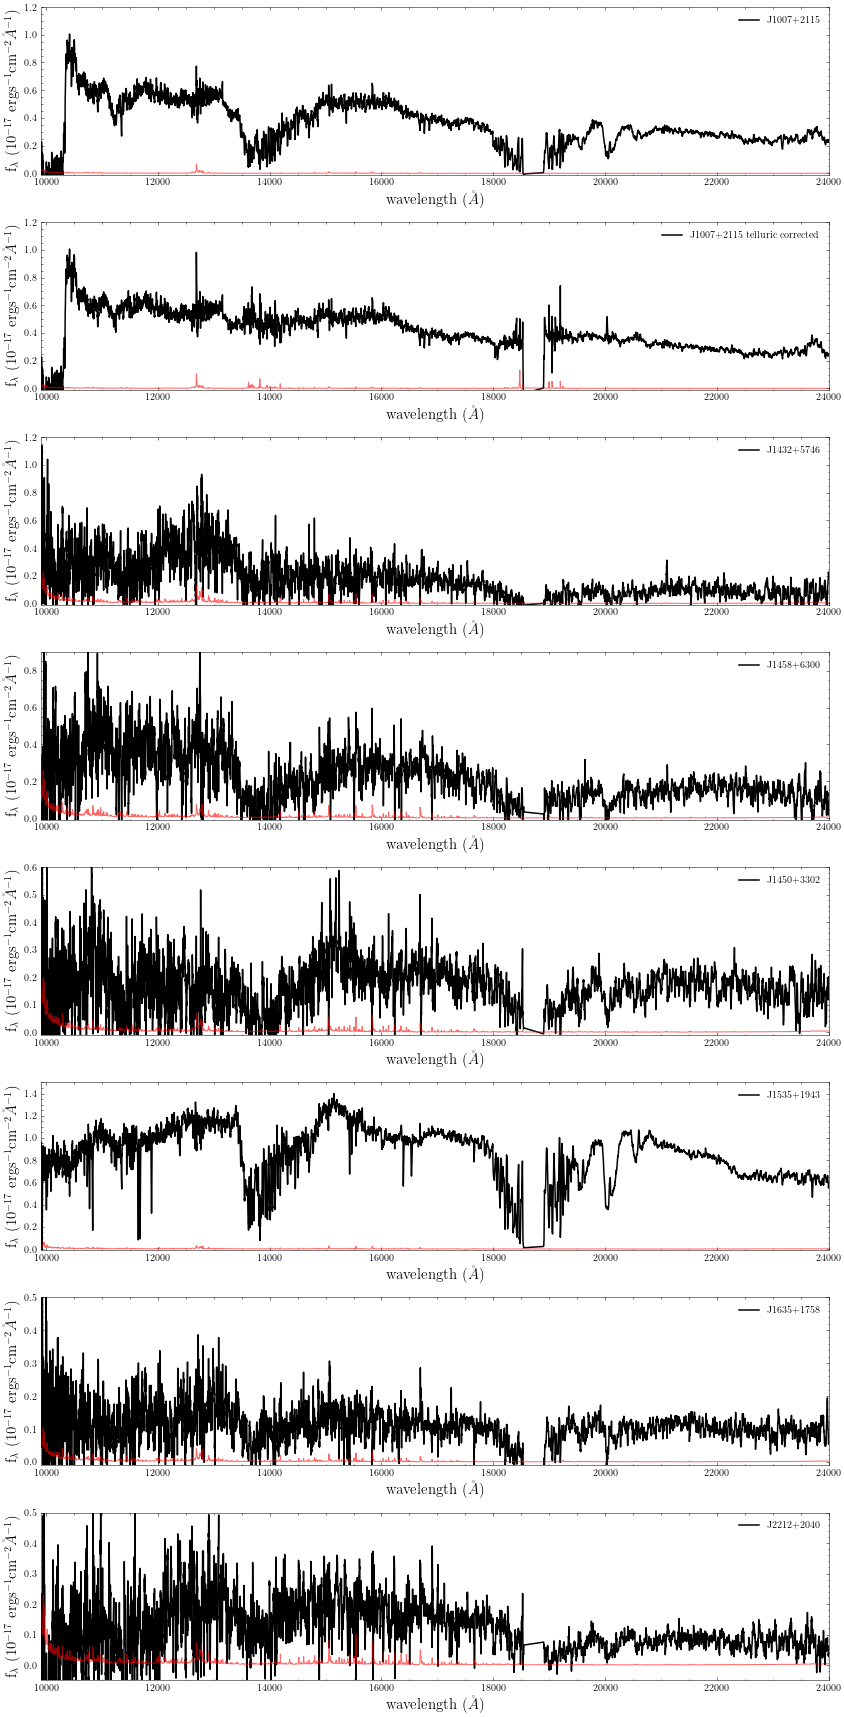

In [4]:
name_list = ["J1007+2115", "J1007+2115 telluric corrected", "J1432+5746", "J1458+6300", 
             "J1450+3302", "J1535+1943", "J1635+1758", "J2212+2040"]
fits_list = ["all/coadd2d/J1007+2115_coadd1d.fits", "all/coadd2d/J1007+2115_coadd1d_tellcorr.fits", 
             "all/coadd2d/J1432+5746_coadd1d.fits", "all/coadd2d/J1458+6300_coadd1d.fits", 
             "all/coadd2d/J1450+3302_coadd1d.fits", "all/coadd2d/J1535+1943_coadd1d.fits", 
             "all/coadd2d/J1635+1758_coadd1d.fits", "all/coadd2d/J2212+2040_coadd1d.fits"]
idx_list = [1, 1, 1, 1, 1, 1, 1, 1]
ylim_list = [(-0.01,1.2), (-0.01,1.2), (-0.01,1.2), (-0.01,0.9), 
             (-0.01,0.6), (-0.01,1.5), (-0.01,0.5), (-0.05,0.5)]
fig, axs = plot(name_list, fits_list, idx_list, ylim_list)
# fig.suptitle("LRIS 2204 (Anniek)", fontsize=25)
# fig.subplots_adjust(top=0.9)

In [ ]:
hdul = fits.open("all/coadd2d/J1007+2115_coadd1d.fits")
output = Table(hdul[1].data)

fig, ax = plt.subplots(figsize=(20,6))

wave = output["wave"]
flux = output["flux"]
flux_ivar = output["ivar"]
# wave = wave / (1 + 7.515)

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="grey", lw=1)
ax.plot(wave, inverse(flux_ivar_sm), lw=1, color="red", alpha=0.6)

hdul = fits.open("all/coadd2d/J1007+2115_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)
flux = output["flux"]
flux_ivar = output["ivar"]

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="black", lw=1)

hdul = fits.open("all/coadd2d/J1007+2115_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
flux = output["TELLURIC"].reshape(len(wave))
ax2 = ax.twinx()
ax2.plot(wave, flux, color="navy", alpha=0.5, lw=0.5, zorder=1)
ax2.set_ylim(0,1.)

ax.set_ylim(-0.01,1.)
# ax.set_xlim(1150, 2900)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)

Text(0, 0.5, 'f$_{\\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\\AA^{-1}$)')

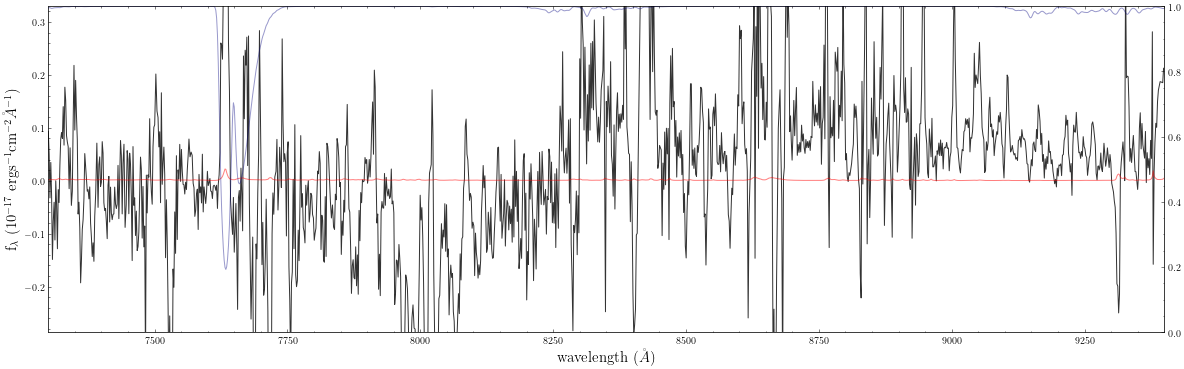

In [99]:
fig, ax = plt.subplots(figsize=(20,6))

hdul = fits.open("J2212+2040_LRIS_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)
wave, flux, flux_ivar = output["wave"], output["flux"], output["ivar"]
mask = (wave<9400)
flux_sm, flux_ivar_sm = ivarsmooth(flux[mask], flux_ivar[mask], 5)
ax.plot(wave[mask], flux_sm, color="black", alpha=0.8, lw=1, label="LRIS")
ax.plot(wave[mask], inverse(flux_ivar_sm), lw=1, color="red", alpha=0.5)

hdul = fits.open("J2212+2040_LRIS_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
wave, flux = output["WAVE"].value[0], output["TELLURIC"].value[0]
ax2 = ax.twinx()
ax2.plot(wave[mask], flux[mask], color="navy", zorder=1, alpha=0.4)

ax2.set_ylim(0,1.)
ax.set_ylim(np.mean(flux_sm)-2*np.std(flux_sm),np.mean(flux_sm)+2*np.std(flux_sm))
ax.set_xlim(7300, 9400)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)
plt.savefig("J2212+2040_LRIS.pdf")

Text(0, 0.5, 'f$_{\\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\\AA^{-1}$)')

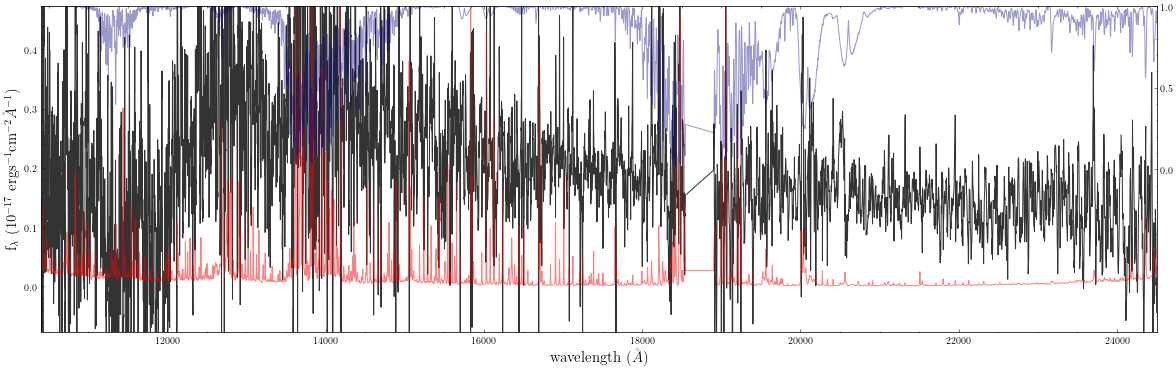

In [101]:
fig, ax = plt.subplots(figsize=(20,6))

hdul = fits.open("J2212+2040_NIRES_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)
wave, flux, flux_ivar = output["wave"], output["flux"], output["ivar"]
mask = (wave>10400)
flux_sm, flux_ivar_sm = ivarsmooth(flux[mask], flux_ivar[mask], 5)
ax.plot(wave[mask], flux_sm, color="black", alpha=0.8, lw=1, label="NIRES")
ax.plot(wave[mask], inverse(flux_ivar_sm), lw=1, color="red", alpha=0.5)

hdul = fits.open("J2212+2040_NIRES_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
wave, flux = output["WAVE"].value[0], output["TELLURIC"].value[0]
ax2 = ax.twinx()
ax2.plot(wave[mask], flux[mask], color="navy", zorder=1, alpha=0.4)

ax2.set_ylim(-1,1)
ax2.set_yticks([0,0.5,1])
ax.set_ylim(np.mean(flux_sm)-2*np.std(flux_sm),np.mean(flux_sm)+2*np.std(flux_sm))
ax.set_xlim(10400, 24500)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)

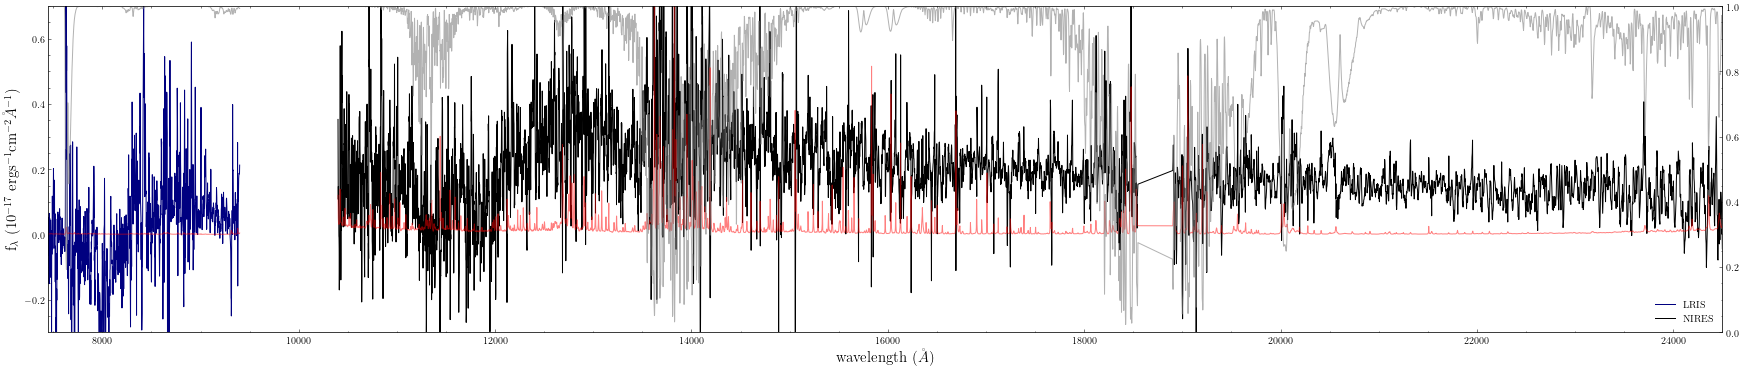

In [80]:
fig, ax = plt.subplots(figsize=(30,6))

hdul = fits.open("J2212+2040_LRIS_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)

wave = output["wave"]
flux = output["flux"]
flux_ivar = output["ivar"]
mask = (wave<9400)

flux_sm, flux_ivar_sm = ivarsmooth(flux[mask], flux_ivar[mask], 5)
ax.plot(wave[mask], flux_sm, color="navy", lw=1, label="LRIS")
ax.plot(wave[mask], inverse(flux_ivar_sm), lw=1, color="red", alpha=0.5)

hdul = fits.open("J2212+2040_LRIS_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
wave = output["WAVE"].value[0]
flux = output["TELLURIC"].value[0]
ax2 = ax.twinx()
ax2.plot(wave[mask], flux[mask], color="grey", zorder=1, alpha=0.6)

hdul = fits.open("J2212+2040_NIRES_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)

wave = output["wave"]
flux = output["flux"]
flux_ivar = output["ivar"]
mask = ((wave>10400))

flux_sm, flux_ivar_sm = ivarsmooth(flux[mask], flux_ivar[mask], 5)
ax.plot(wave[mask], flux_sm, color="black", lw=1, label="NIRES")
ax.plot(wave[mask], inverse(flux_ivar_sm), lw=1, color="red", alpha=0.5)

hdul = fits.open("J2212+2040_NIRES_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
wave = output["WAVE"].value[0]
flux = output["TELLURIC"].value[0]
ax2.plot(wave[mask], flux[mask], color="grey", zorder=1, alpha=0.6)

ax2.set_ylim(0,1)

ax.legend(loc="lower right")
ax.set_ylim(-0.3,0.7)
ax.set_xlim(7450, 24500)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)

plt.savefig("J2212_LRIS+NIRES.pdf")

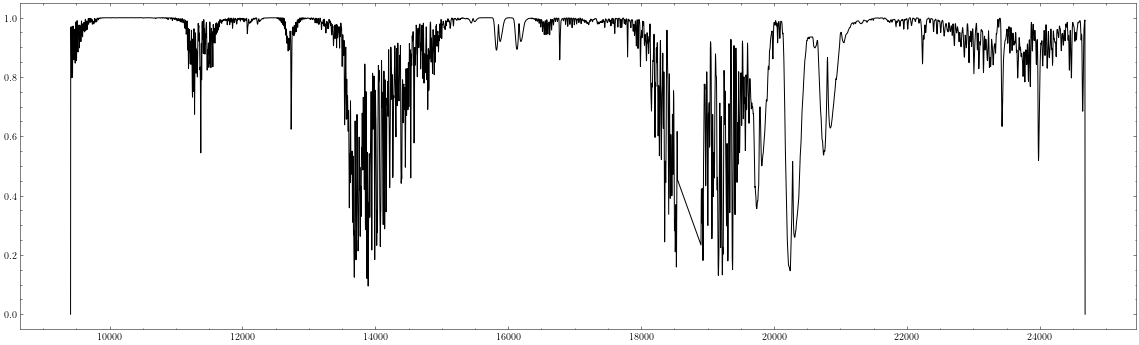

In [45]:
hdul = fits.open("J2212+2040_NIRES_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
wave = output["WAVE"].value[0]
flux = output["TELLURIC"].value[0]

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(wave, flux, color="black", zorder=1)
# ax.set_ylim(0,1.)

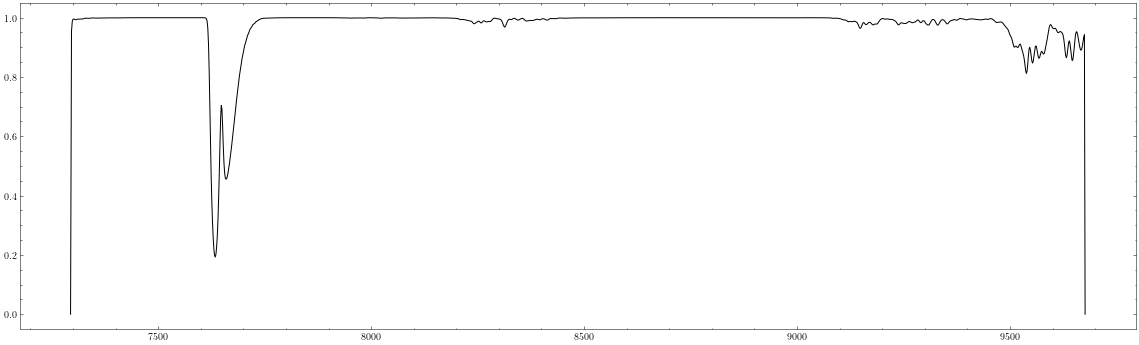

In [55]:
hdul = fits.open("J2212+2040_LRIS_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
wave = output["WAVE"].value[0]
flux = output["TELLURIC"].value[0]

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(wave, flux, color="black", zorder=1)
# ax.set_ylim(0,1.)

In [ ]:
hdul = fits.open("all_2/coadd2d/J1535+1943_coadd1d.fits")
output = Table(hdul[1].data)

fig, ax = plt.subplots(figsize=(20,6))

wave = output["wave"]
flux = output["flux"]
flux_ivar = output["ivar"]
wave = wave / (1 + 7.515)

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="grey", lw=1)
ax.plot(wave, inverse(flux_ivar_sm), lw=1, color="red", alpha=0.6)

hdul = fits.open("all/coadd2d/J1535+1943_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)
flux = output["flux"]
flux_ivar = output["ivar"]

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="black", lw=1)

ax.set_ylim(-0.01,2.)
ax.set_xlim(1150, 2900)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)

Text(0, 0.5, 'f$_{\\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\\AA^{-1}$)')

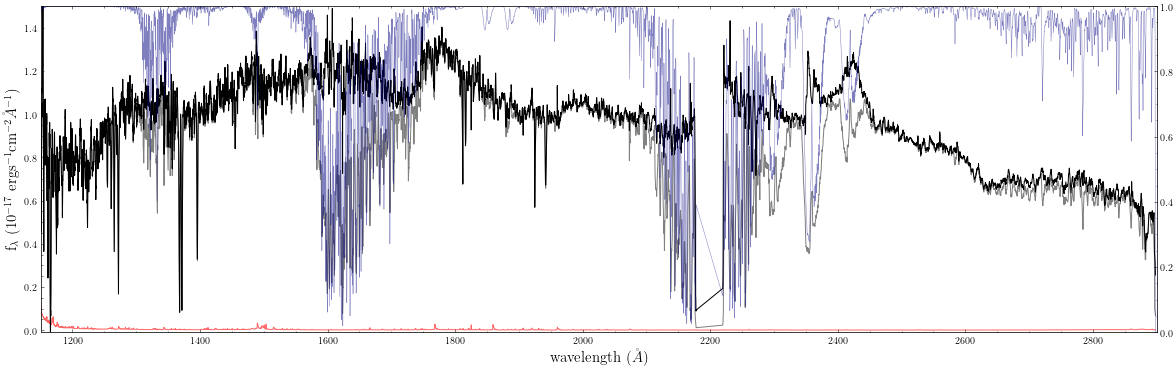

In [42]:
hdul = fits.open("all/coadd2d/J1535+1943_coadd1d.fits")
output = Table(hdul[1].data)

fig, ax = plt.subplots(figsize=(20,6))

wave = output["wave"]
flux = output["flux"]
flux_ivar = output["ivar"]
wave = wave / (1 + 7.515)

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="grey", lw=1)
ax.plot(wave, inverse(flux_ivar_sm), lw=1, color="red", alpha=0.6)

hdul = fits.open("all/coadd2d/J1535+1943_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)
flux = output["flux"]
flux_ivar = output["ivar"]

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="black", lw=1)

hdul = fits.open("all/coadd2d/J1535+1943_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
flux = output["TELLURIC"].reshape(len(wave))
ax2 = ax.twinx()
ax2.plot(wave, flux, color="navy", alpha=0.5, lw=0.5, zorder=1)
ax2.set_ylim(0,1.)

ax.set_ylim(-0.01,1.5)
ax.set_xlim(1150, 2900)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)

Text(0, 0.5, 'f$_{\\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\\AA^{-1}$)')

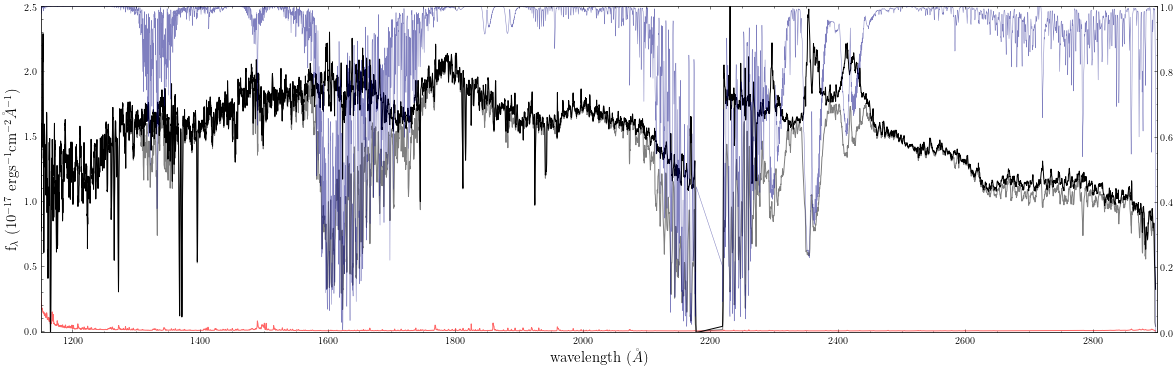

In [45]:
hdul = fits.open("all_2/coadd2d/J1535+1943_coadd1d.fits")
output = Table(hdul[1].data)

fig, ax = plt.subplots(figsize=(20,6))

wave = output["wave"]
flux = output["flux"]
flux_ivar = output["ivar"]
wave = wave / (1 + 7.515)

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="grey", lw=1)
ax.plot(wave, inverse(flux_ivar_sm), lw=1, color="red", alpha=0.6)

hdul = fits.open("all_2/coadd2d/J1535+1943_coadd1d_tellcorr.fits")
output = Table(hdul[1].data)
flux = output["flux"]
flux_ivar = output["ivar"]

flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 7)
ax.plot(wave, flux_sm, color="black", lw=1)

hdul = fits.open("all_2/coadd2d/J1535+1943_coadd1d_tellmodel.fits")
output = Table(hdul[1].data)
flux = output["TELLURIC"].reshape(len(wave))
ax2 = ax.twinx()
ax2.plot(wave, flux, color="navy", alpha=0.5, lw=0.5, zorder=1)
ax2.set_ylim(0,1.)

ax.set_ylim(-0.01,2.5)
ax.set_xlim(1150, 2900)
ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)